<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

Data augmentation is a technique that increases teh fiversity of your training set by applying random (but realistic) transformations such as image rotation. TF enables a couple of approach to implement data augmentation: `keras preprocessing layers` and `tf.image`.

## Setup

In [1]:
!nvidia-smi

Sat Nov  7 23:33:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

f'Tensorflow version: {tf.__version__}'

'Tensorflow version: 2.3.0'

## Download a dataset

This tutorial uses tf_flowers dataset.

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[:90%]'],
    with_info=True,
    as_supervised=True,
)

print(f'# images train_ds: {tf.data.experimental.cardinality(train_ds)}')
print(f'# images val_ds: {tf.data.experimental.cardinality(val_ds)}')
print(f'# images test_ds: {tf.data.experimental.cardinality(test_ds)}')

# images train_ds: 2936
# images val_ds: 367
# images test_ds: 3303


The flowers dataset has five classes.

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrive an image from the dataset and use it to demostrate data augmentation.

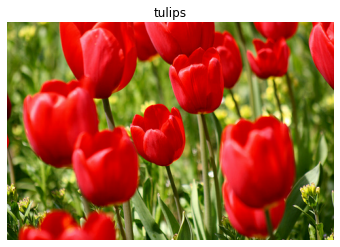

In [5]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image);
_ = plt.title(get_label_name(label));
plt.axis('off');

### User Keras processing layers

#### Resizing and scaling

You can use preprocessing layers to resize your images to a consistent shape, and to rescale pixel values.

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

Note: the rescaling layer above standardize pixel values to `[0, 1]`. If instead you wanted `[-1, 1]`, you would write `Rescaling(1.0/127.5, offset=-1)`.

You can see the result of applying these layers to an image.

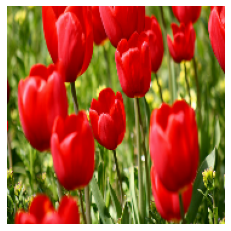

In [7]:
result = resize_and_rescale(image)
plt.axis('off')
_ = plt.imshow(result)

You can verify the pixels are in `[0, 1]`.

In [8]:
f'Min and max pixel values: {result.numpy().min()},  {result.numpy().max()}'

'Min and max pixel values: 0.0,  1.0'

#### Data Augmentation

You can use preprocessing layers for data augmentation as well. Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
image.shape

TensorShape([333, 500, 3])

In [11]:
# add image to batch
batch_image = tf.expand_dims(image, 0)

In [12]:
batch_image.shape

TensorShape([1, 333, 500, 3])

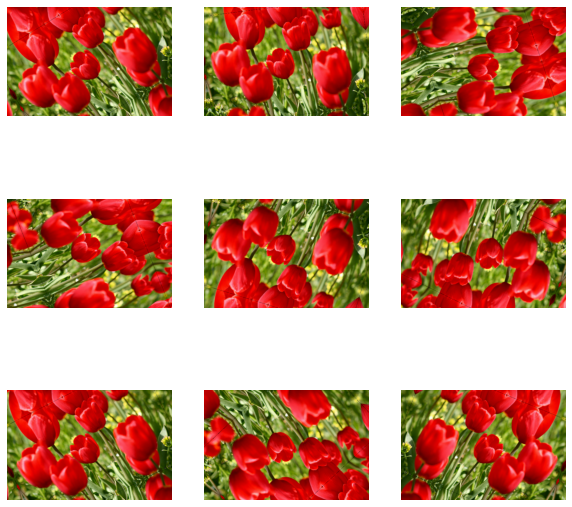

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(batch_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

There are a variety of processing layers you can use for data augmentation including `layers.RandomContrast`, `layers.RandomCrop`, `layers.RandomZoom`, and others.

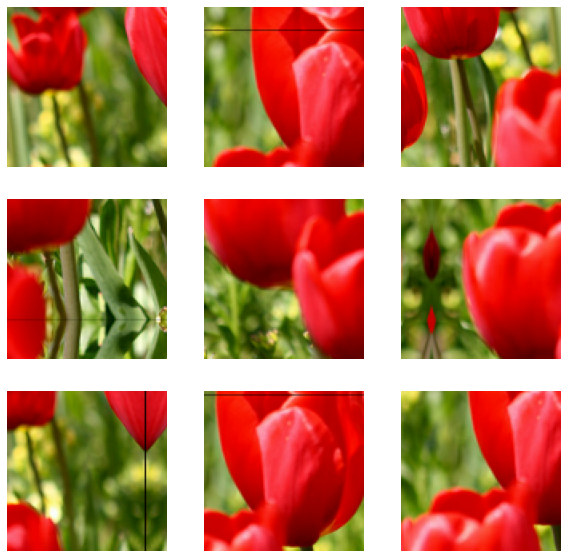

In [14]:
data_augmentation_zoom_and_crop = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomCrop(height=100, width=100)
])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation_zoom_and_crop(batch_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

There are two ways you can use these preprocessing layers, with important tradeoffs. 

Option #1. Make preprocessing layers part of your model

In [17]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # rest of your model                     
])

There are two important points to be aware of in this case:

1. Data augmentation will run on-devise, synchronously with the rest of your layers, and benefit from GPU acceleration.

2. When yu export your model using model.save, the processing layers will be saved alogn with the rest of you model. If you later deploy this model, it will automatically standaridize image (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during call to `model.fit` (not `model.evaluate` or `model.predict`).